In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve, 
    auc
)
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [141]:
# Load and preprocess data
X_train = pd.read_csv('../Data/X_train.csv')
X_test = pd.read_csv('../Data/X_test.csv')
y_train = pd.read_csv('../Data/y_train.csv').squeeze()
y_test = pd.read_csv('../Data/y_test.csv').squeeze()
X_train = X_train.drop('company', axis=1)
X_test = X_test.drop('company', axis=1)
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}
for col in ['industry', 'stage', 'region', 'layoff_events_category', 'funds_raised_binned']:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    X_test_encoded[col] = le.transform(X_test[col])
    label_encoders[col] = le

# 保存 encoder
joblib.dump(label_encoders, '../Model/label_encoders.pkl')

print(f"Train: {X_train_encoded.shape} | Test: {X_test_encoded.shape}")
print(f"Features: {X_train_encoded.columns.tolist()}\n")
print("Label encoders saved!")

Train: (968, 9) | Test: (242, 9)
Features: ['industry', 'stage', 'funds_raised', 'region', 'recency', 'events_deviation', 'recency_deviation', 'layoff_events_category', 'funds_raised_binned']

Label encoders saved!


In [142]:
# Train Decision Tree with hyperparameter tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    {'max_depth': [3, 5, 7, 8, 10, 12, 15, 18, 20], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 3, 4, 5]},
    cv=cv, n_jobs=-1, scoring='f1', verbose=0
)
dt_grid.fit(X_train_encoded, y_train)
dt_best = dt_grid.best_estimator_
print(f"Decision Tree CV F1: {dt_grid.best_score_:.4f}")

Decision Tree CV F1: 0.5557


In [143]:
# Train Random Forest with ~
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    {'n_estimators': [100, 150, 200, 250, 300], 'max_depth': [8, 10, 12, 15, 18, 20], 'min_samples_split': [1, 2, 5, 8], 'min_samples_leaf': [2, 4, 5, 6], 'max_features': ['sqrt', 'log2']},
    cv=cv, n_jobs=-1, scoring='f1', verbose=0
)
rf_grid.fit(X_train_encoded, y_train)
rf_best = rf_grid.best_estimator_
print(f"Random Forest CV F1: {rf_grid.best_score_:.4f}")

Random Forest CV F1: 0.6348


In [144]:
# Train XGBoost with conservative improved tuning
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_grid = GridSearchCV(
    xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1, eval_metric='logloss'),
    {'max_depth': [3, 4, 5, 6, 7, 8], 
     'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1], 
     'n_estimators': [300, 500, 800, 1000], 
     'subsample': [0.7, 0.8, 0.9, 1.0], 
     'colsample_bytree': [0.7, 0.8, 0.9, 1.0]},
    cv=cv, n_jobs=-1, scoring='f1', verbose=0
)
xgb_grid.fit(X_train_encoded, y_train)
xgb_best = xgb_grid.best_estimator_
print(f"XGBoost CV F1: {xgb_grid.best_score_:.4f}\n")

XGBoost CV F1: 0.6413



In [145]:
# Generate predictions on test set
dt_pred = dt_best.predict(X_test_encoded)
dt_pred_proba = dt_best.predict_proba(X_test_encoded)[:, 1]

rf_pred = rf_best.predict(X_test_encoded)
rf_pred_proba = rf_best.predict_proba(X_test_encoded)[:, 1]

xgb_pred = xgb_best.predict(X_test_encoded)
xgb_pred_proba = xgb_best.predict_proba(X_test_encoded)[:, 1]

# Evaluate all models
def eval_model(y_true, y_pred, y_pred_proba, name):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_true, y_pred_proba),
    }

results = [
    eval_model(y_test, dt_pred, dt_pred_proba, 'Decision Tree'),
    eval_model(y_test, rf_pred, rf_pred_proba, 'Random Forest'),
    eval_model(y_test, xgb_pred, xgb_pred_proba, 'XGBoost')
]
results_df = pd.DataFrame(results)

print("TEST SET PERFORMANCE")
print(results_df.to_string(index=False))

print("\nBEST PARAMETERS")
print(f"Decision Tree: {dt_grid.best_params_}")
print(f"Random Forest: {rf_grid.best_params_}")
print(f"XGBoost: {xgb_grid.best_params_}")

# Display confusion matrices
print("\nCONFUSION MATRICES")
tn, fp, fn, tp = confusion_matrix(y_test, dt_pred).ravel()
print(f"Decision Tree: TP={tp} FP={fp} FN={fn} TN={tn}")
tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()
print(f"Random Forest: TP={tp} FP={fp} FN={fn} TN={tn}")
tn, fp, fn, tp = confusion_matrix(y_test, xgb_pred).ravel()
print(f"XGBoost: TP={tp} FP={fp} FN={fn} TN={tn}")

TEST SET PERFORMANCE
        Model  Accuracy  Precision   Recall       F1      AUC
Decision Tree  0.714876   0.602564 0.552941 0.576687 0.756763
Random Forest  0.776860   0.674157 0.705882 0.689655 0.835594
      XGBoost  0.785124   0.673684 0.752941 0.711111 0.837467

BEST PARAMETERS
Decision Tree: {'max_depth': 18, 'min_samples_leaf': 3, 'min_samples_split': 7}
Random Forest: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 250}
XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}

CONFUSION MATRICES
Decision Tree: TP=47 FP=31 FN=38 TN=126
Random Forest: TP=60 FP=29 FN=25 TN=128
XGBoost: TP=64 FP=31 FN=21 TN=126


In [146]:
display(results_df.style.set_properties(**{'text-align': 'center'}).format({
    'Accuracy': '{:.6f}',
    'Precision': '{:.6f}',
    'Recall': '{:.6f}',
    'F1': '{:.6f}',
    'AUC': '{:.6f}'
}))

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree,0.714876,0.602564,0.552941,0.576687,0.756763
1,Random Forest,0.776860,0.674157,0.705882,0.689655,0.835594
2,XGBoost,0.785124,0.673684,0.752941,0.711111,0.837467


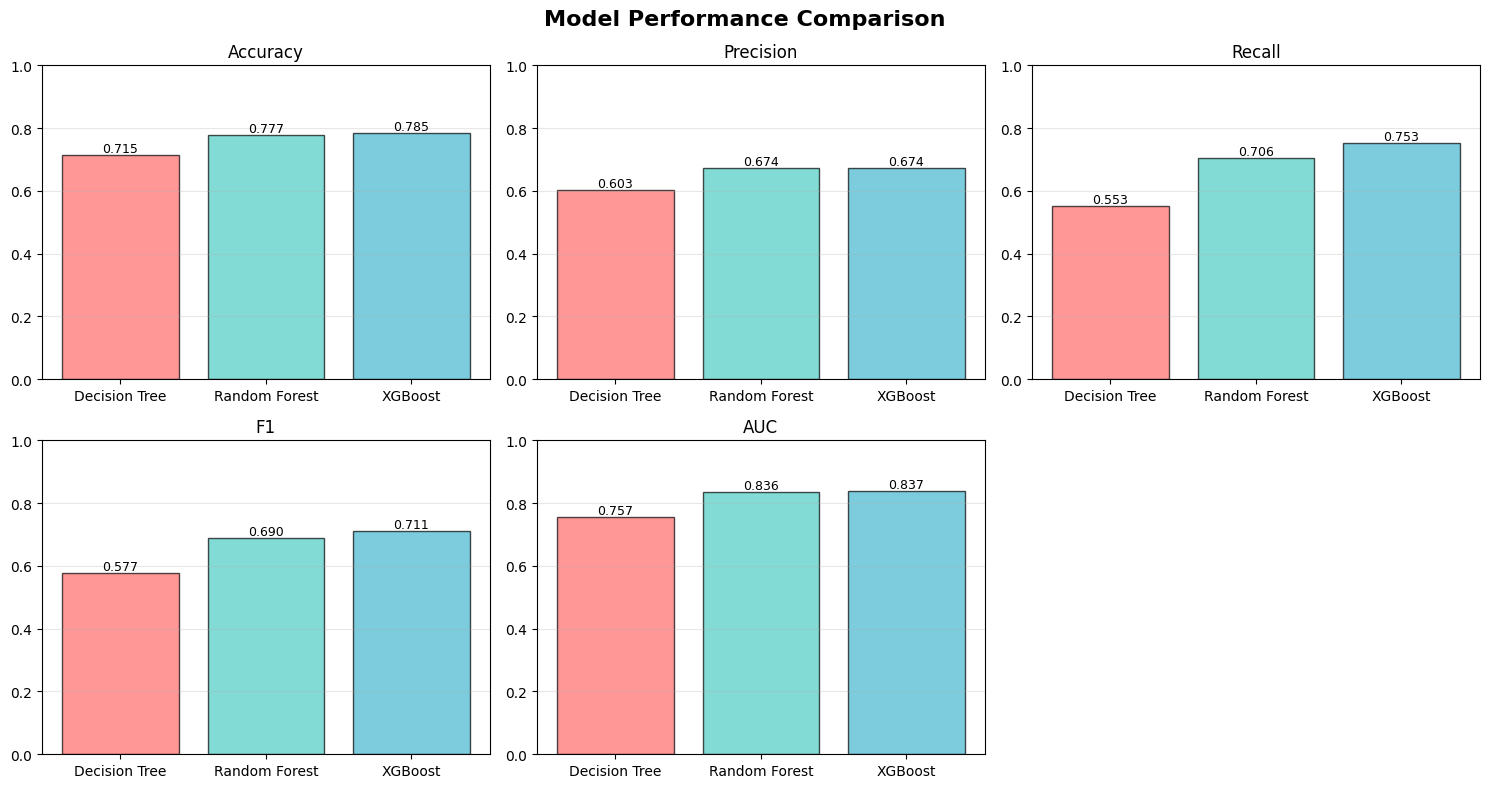

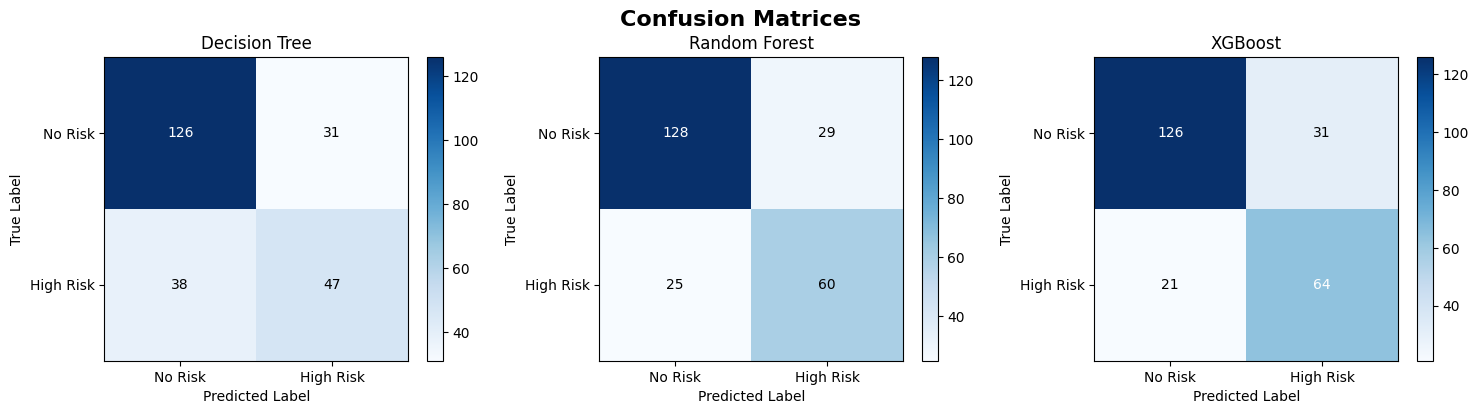

In [147]:
# 1. Model Performance Comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Bar plots for 5 metrics
for idx, metric in enumerate(metrics):
    ax = axes.flat[idx]
    values = results_df[metric].values
    bars = ax.bar(results_df['Model'], values, color=colors, alpha=0.7, edgecolor='black')

    ax.set_ylim([0, 1])
    ax.set_title(metric)
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

# Hide the 6th subplot
axes.flat[5].axis('off')



plt.tight_layout()
plt.show()

# 2. Confusion Matrices Heatmap
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

models = [
    ('Decision Tree', dt_pred),
    ('Random Forest', rf_pred),
    ('XGBoost', xgb_pred)
]

for idx, (name, pred) in enumerate(models):
    cm = confusion_matrix(y_test, pred)
    im = axes[idx].imshow(cm, interpolation='nearest', cmap='Blues')
    axes[idx].figure.colorbar(im, ax=axes[idx])
    
    # Add value labels
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, str(cm[i, j]),
                          ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    
    axes[idx].set_title(name)
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels(['No Risk', 'High Risk'])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_yticklabels(['No Risk', 'High Risk'])

plt.tight_layout()
plt.show()

In [148]:
def explain_matrix(model_name, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"[{model_name}]")
    print(f"TP (True Positive)   = {tp}  → correctly identified high-risk companies")
    print(f"FP (False Positive)  = {fp}  → predicted high-risk but actually safe")
    print(f"FN (False Negative)  = {fn}  → predicted safe but actually high-risk")
    print(f"TN (True Negative)   = {tn}  → correctly identified safe companies")

explain_matrix("Decision Tree", dt_pred)
explain_matrix("Random Forest", rf_pred)
explain_matrix("XGBoost", xgb_pred)

[Decision Tree]
TP (True Positive)   = 47  → correctly identified high-risk companies
FP (False Positive)  = 31  → predicted high-risk but actually safe
FN (False Negative)  = 38  → predicted safe but actually high-risk
TN (True Negative)   = 126  → correctly identified safe companies
[Random Forest]
TP (True Positive)   = 60  → correctly identified high-risk companies
FP (False Positive)  = 29  → predicted high-risk but actually safe
FN (False Negative)  = 25  → predicted safe but actually high-risk
TN (True Negative)   = 128  → correctly identified safe companies
[XGBoost]
TP (True Positive)   = 64  → correctly identified high-risk companies
FP (False Positive)  = 31  → predicted high-risk but actually safe
FN (False Negative)  = 21  → predicted safe but actually high-risk
TN (True Negative)   = 126  → correctly identified safe companies


In [149]:
# FP high means model is over-sensitive and flags safe companies as risky.
# FN high means model misses truly high-risk companies.
# Comparing FP/FN across models helps determine the safest and most reliable one.

In [150]:
best_idx = results_df['F1'].idxmax()
print(f"BEST MODEL: {results_df.loc[best_idx, 'Model']} (F1={results_df.loc[best_idx, 'F1']:.4f})")

BEST MODEL: XGBoost (F1=0.7111)


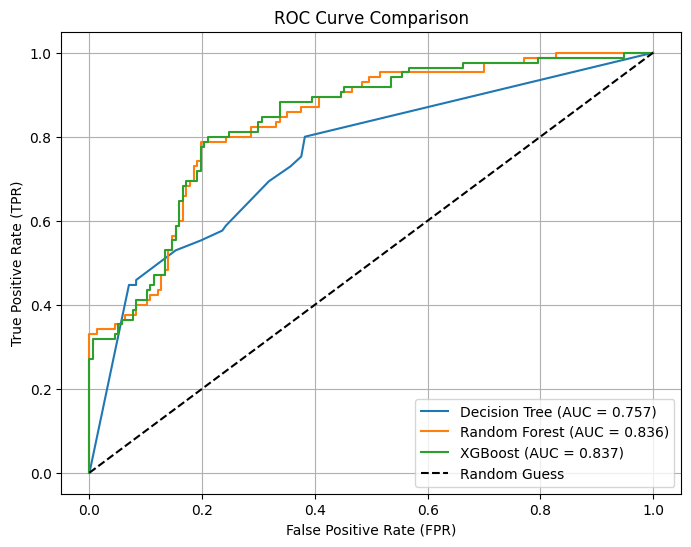

In [151]:
plt.figure(figsize=(8, 6))

# ROC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_pred_proba)
auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.3f})")

# ROC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")

# ROC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True)
plt.show()

In [152]:
joblib.dump(dt_best, '../Model/decision_tree_model.pkl')
joblib.dump(rf_best, '../Model/random_forest_model.pkl')
joblib.dump(xgb_best, '../Model/xgboost_model.pkl')
print("Models saved successfully")

Models saved successfully
